In [1]:
import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
pv.set_jupyter_backend('static')
import sys

sys.path.append("../../")
import ArchPy
from ArchPy.base import *

In [2]:
P1 = Pile(name="P1",seed=1)

In [3]:
#grid
sx = 15
sy = 15
sz = 4
x1 = 2000
y1 = 3000
z1 = 201
x0 = 0
y0 = 0
z0 = 0
nx = int((x1-x0)/sx)
ny = int((y1-y0)/sy)
nz = int((z1-z0)/sz)

xg = np.linspace(x0,x1,nx+1)
yg = np.linspace(y0,y1,ny+1)
zg = np.linspace(z0,z1,nz+1)
sx = xg[1] - xg[0]
sy = yg[1] - yg[0]
sz = zg[1] - zg[0]

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)

## define a TI for simulations

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x1baeceede88>)

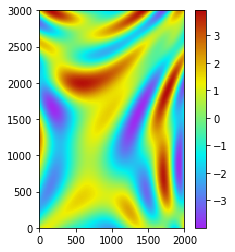

In [4]:
def topo(x,y):
    x /= 400
    y /= 400
    res = (np.sin(-(x-2)**2+1/7*(y-2)**2)) + \
    (np.sin(-(x-1)**2+1/2*(y-1)**2))+ \
    2*(np.sin(-(x-2)**2+1/2*(y-3)**2)) 
    
    #res[res<0] = 0
    return res


X,Y = np.meshgrid(xg[1:],yg[1:])
dd = topo(X,Y)

topoC = geone.img.Img(nx, ny, 1, sx, sy, 1, nv = 1, val=dd.reshape(1,ny,nx))
imgplt.drawImage2D(topoC)

## Define the units

C top will be simulate using the TI just above. Some parameters can be defined to control the simulation.
The TI hasn't the same range as target (C top), it is necessary to rescale the TI and this is done by setting the following parameters :
- ``rescalingMode`` : method to use for the rescaling --> min_max or length
- ``TargetMax`` : max value that will be simulated (the TI max value will be set to this value)
- ``TargetMin`` : identical to TargetMin except it is for a minimum value

others are available such as TargetMean and TargetLength, see DeeSse documentation on continous simulations

In [5]:
## Surfaces covmodel
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':100, 'r':[500,1000]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':200, 'r':[600,800]})])
covmodelA = gcm.CovModel2D(elem=[('spherical', {'w':200, 'r':[600,3000]})])

#create Lithologies 
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface())

dic_s_C = {"int_method" : "MPS","TI" : topoC,"TargetMin":80, "TargetMax": 180, "rescalingMode":"min_max",
          "thresh":0.01,"maxscan":0.1}
C = Unit(name="C",order=2,ID = 2,color="midnightblue",contact="onlap",surface=Surface(dic_surf=dic_s_C,contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean" : 100}
B = Unit(name="B",order=3,ID = 3,color="green",contact="onlap",surface=Surface(contact="erode",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel" : covmodelA, "mean" : 30}
A = Unit(name="A",order=4,ID = 4,color="lightcoral",contact="onlap",surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


In [6]:
#We must create an ArchTable object and set a Pile master (first pile)
T1 = Arch_table(name = "P1",seed=1, working_directory = "ws_mps")
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin) #add grid

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##


In [7]:
T1.process_bhs()

##### ORDERING UNITS ##### 
Pile P1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set
No borehole found - no hd extracted


In [8]:
T1.compute_surf(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
Unit A has no inequality point, the interpolation method is switched to GRF
A: time elapsed for computing surface 0.02101922035217285 s

#### COMPUTING SURFACE OF UNIT B
Unit B has no inequality point, the interpolation method is switched to GRF
B: time elapsed for computing surface 0.010009050369262695 s

#### COMPUTING SURFACE OF UNIT C
DeeSse running... [VERSION 3.2 / BUILD NUMBER 20211103 / OpenMP 15 thread(s)]
DeeSse run complete
C: time elapsed for computing surface 0.22878575325012207 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.14378762245178223 s
##########################


### 0.4216172695159912: Total time elapsed for computing surfaces ###


In [9]:
pv.set_jupyter_backend("static")

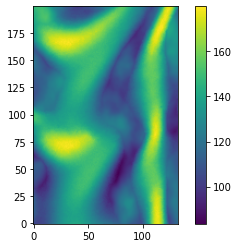

In [10]:
plt.imshow(T1.get_surfaces_unit(C)[0], origin="lower")
plt.colorbar()

C:\Users\emmal\Anaconda3\envs\LS\lib\site-packages\pyvista\core\dataset.py:1335: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  PyvistaDeprecationWarning


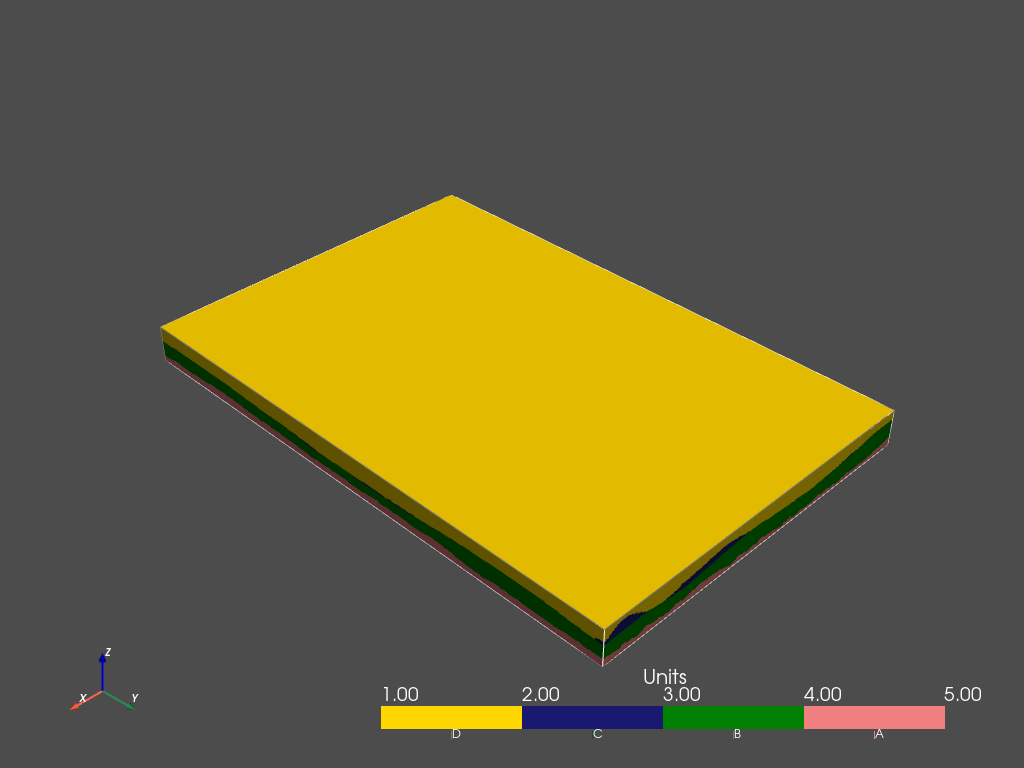

In [11]:
T1.plot_units(0)

## Sample some boreholes to conditionate simulations

This is done with ``create_fake_bh(x, y)``

In [12]:
#sample boreholes
n = 30
x = np.random.uniform(x0, x1, n)
y = np.random.uniform(y0, y1, n)

l_bhs = []
for ix, iy in zip(x, y):
    l_bhs.append(T1.create_fake_bh(ix, iy, facies=False))


In [13]:
T1.add_bh(l_bhs)

point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outside of the grid in z
Borehole dummy added
point outsid

In [14]:
T1.reprocess()

Hard data reset
##### ORDERING UNITS ##### 
Pile P1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set
Processing ended successfully


## Check HD

In [15]:
C.surface.ineq

[[1179.9240764013277, 1471.0735917160416, 0, nan, 120.6],
 [1229.9731390503434, 1894.9998577129156, 0, nan, 104.52],
 [1308.2634921544552, 1978.1070091759289, 0, nan, 104.52],
 [1254.7523444750084, 826.1598524424229, 0, nan, 88.44],
 [1156.4803566811968, 2002.0478639515052, 0, nan, 104.52]]

In [16]:
T1.compute_surf(10)

########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.03102731704711914 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.017016172409057617 s

#### COMPUTING SURFACE OF UNIT C
DeeSse running... [VERSION 3.2 / BUILD NUMBER 20211103 / OpenMP 15 thread(s)]
DeeSse run complete
C: time elapsed for computing surface 0.21215271949768066 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.14212989807128906 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.032028913497924805 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.017015695571899414 s

#### COMPUTING SURFACE OF UNIT C
DeeSse running... [VERSION 3.2 / BUILD NUMBER 20211103 / OpenMP 15 thread(s)]
DeeSse run complete
C: time elapsed for computing surface 0.2121927738189

C:\Users\emmal\Anaconda3\envs\LS\lib\site-packages\pyvista\core\dataset.py:1335: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  PyvistaDeprecationWarning


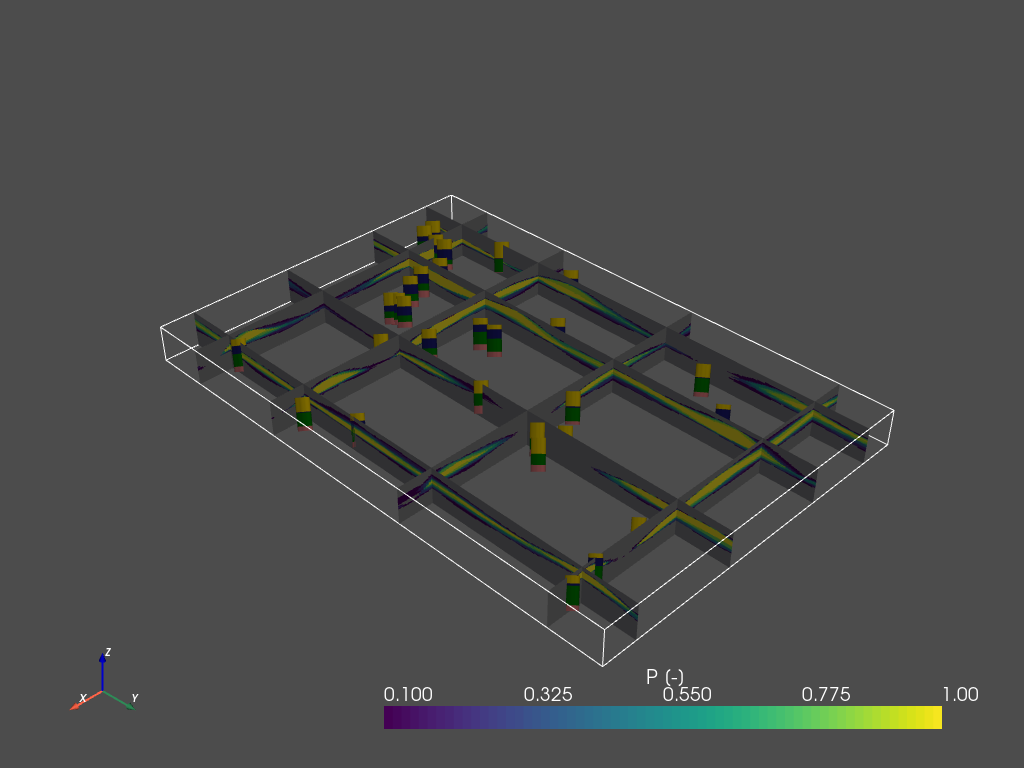

In [17]:
p = pv.Plotter()

#T1.plot_units(2,plotter=p, slicey=(0.1, 0.31, 0.6, 0.9),slicex=(0.1, 0.8, 0.3, 0.6, 0.9))
T1.plot_proba(C, plotter=p, slicey=(0.1, 0.3, 0.6, 0.9),slicex=(0.1, 0.3, 0.6, 0.9))
T1.plot_bhs(plotter=p)
p.show()

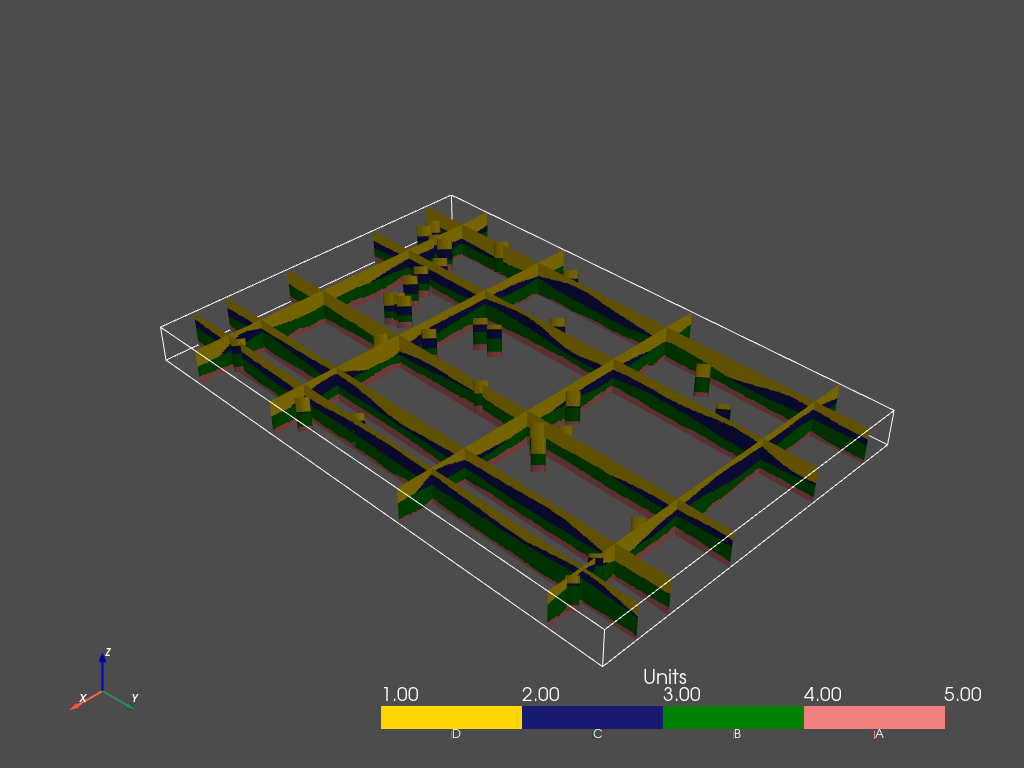

In [18]:
p = pv.Plotter()

T1.plot_units(2,plotter=p, slicey=(0.1, 0.3, 0.6, 0.9),slicex=(0.1, 0.8, 0.3, 0.6, 0.9))
T1.plot_bhs(plotter=p)
p.show()